In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from numpy.random import default_rng

# ML/Clustering stuff
#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action="ignore")


In [2]:
# CONFIG

DATA_PATH = "/Volumes/karsten.schroer@uni-koeln.de/Uni/Research/04_CASE_Clustered_EV_Charging/"
OUT_PATH = ""

In [3]:
def set_plotting_style(palette="mako"):
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")
    # Set the font to be serif, rather than sans
    sns.set(font='serif')

    # define colors
    sns.set_palette(palette, n_colors=9)
    # project_even_cols = [[44 / 255, 25 / 255, 149 / 255, .75], [147 / 255, 41 / 255, 223 / 255, .75],[0 / 255, 9 / 255, 43 / 255, .75]]

    # Make the background white, and specify the font family
    sns.set_style("ticks", {"font.family": "serif", "font.serif": ["Times", "Palatino", "serif"]})

In [4]:
set_plotting_style()

Preference Routine is as follows:

1. Arrival and Departure Patterns:
    - We use APCOA Parking Data to determine stochastic arrival ($A$), stay duration ($\delta$) and departure ($D$) preferences
1. Request Charging Y/N:
    - EV share ($\sigma_{EV}$): For each vehicle we select the propulsion technology probilistically based on a Brenoulli Process with $p(EV)=\sigma_{EV}$ and $p(ICE)=(1-\sigma_{EV})$
    - Charge Y/N: Per each EV we decide whether the vehicle requires charging or not. We model this as probability distribution conditional on duration of stay $p(charge=True | \delta)$
1. Exact Charge Demand:
    - Option I: Collaborative Filtering using ACN Data
    - Option II: Simplified Transportation Demand Model, assuming daily commuting distances and home charging opportunity (Y/N)
    - Option III: Assume start and end SOC as well as battery sizes (likely the inverior option)

### Arrival and Departure Patterns (clustered)

This is ground-truth data for time of entry, stay duration, time of exit

In [5]:
# Load Data
parkings = pd.read_csv(DATA_PATH+"EV_Energy_Demand_Data/Parking+Charging_Data_BLENDED_CLUSTERED_v2.csv")
parkings = parkings[['EntryDateTime', 'ExitDateTime', 'HoursStay', 'MinutesStay', 'RevenueAmount', 'SiteID', 
                     'Year','EntryMFM', 'ExitMFM', 'EntryDate', 'ExitDate', 'EntryHour', 'ExitHour','EntryDayOfWeek', 
                     'EntryWeekday_yn', 'EntryHoliday_yn','userInputs_kWhRequested','ClusterName']] #'ClusterName',

# limit parking duration to 48h (let's not do this for now!)
parkings = parkings[parkings["MinutesStay"]<48*60]

# some info
print("Num facilities: {}".format(len(parkings["SiteID"].unique())))
print("Num parking events: {}".format(len(parkings)))

Num facilities: 7
Num parking events: 3843007


In [6]:
parkings["SiteID"].unique()

array(['Facility_1', 'Facility_2', 'Facility_3', 'Facility_4',
       'Facility_5', 'Facility_6', 'Facility_KoeBogen'], dtype=object)

In [7]:
parkings = parkings[parkings["SiteID"]=="Facility_3"]

In [8]:
min_dt= "2019-06-03"
max_dt= "2019-06-09"

In [9]:
parkings = parkings[(parkings["EntryDateTime"]>=min_dt)&(parkings["EntryDateTime"]<=max_dt)]

In [10]:
len(parkings)

14791

### EV Y/N

This is modelled as a simple Bernoulli distribution which takes the value 1 with probability $p=\sigma_{EV}$ and the value 0 with probability $q = 1-p$, i.e., EV is generated via a Brenoulli process

In [11]:
def sample_electric_vehicles(df, ev_share, seed=42):
    """
    Selects whether parked vehicle is an EV with probability p=ev_share. Sets energy demand of vehicles
    that have been set to ICE to 0 kWh
    :param df:
    :param ev_share: [0,1]
    :param seed: seed of random generator, if undefined set to None
    :return: adds colums EV_yn and "final_kWhRequested_updated"
    """
    # NOTE: TESTED AND PASSED

    if ev_share > 1 or ev_share < 0:
        raise ValueError("EV share must be in interval [0,1]!!!")

    # instantiate random number generator
    rng = default_rng(seed=seed)

    # randomly select EV with p=ev_share
    ev_array = rng.choice([0, 1], p=[1 - ev_share, ev_share], size=len(df))

    # match to df
    df["EV_yn"] = ev_array

    # update energy demand, set to 0 if not an EV
    #df["final_kWhRequested_updated"] = df["EV_yn"] * df["final_kWhRequested"]

    return df

In [12]:
parkings = sample_electric_vehicles(parkings, ev_share=1, seed=42)

### Request Charging Y/N

(for now just have a min threshold)

In [13]:
def sample_charge_request_yn(df, min_stay_minutes):
    """
    xxx
    :param df:
    :param ev_share: [0,1]
    :param seed: seed of random generator, if undefined set to None
    :return: adds colums EV_yn and "final_kWhRequested_updated"
    """
    
    # Conditional Expectation of Success given Planned Duration of Stay 
    # Use probability in Brenoulli Process to define whether there is a charge request
    
    # For now: assume minimum stay duration of XX
     
    df["request_charge_yn"] = df.apply(lambda x: 1 if x.EV_yn==1 and x.MinutesStay>=min_stay_minutes else 0, axis=1)

    return df

### Charge Quantity Request

#### Collaborative Filtering Appraoch
(DO THIS AFTER DAYS HAVE BEEN SELECTED DUE TO LONG RUNTIME)

In [14]:
def generate_energy_demand_coll_filter_approach(df,ev_share,min_stay_minutes,max_charge_rate,seed):
    
    df = sample_electric_vehicles(df, ev_share, seed=seed)
    df = sample_charge_request_yn(df,min_stay_minutes)
    
    # update charge request
    
    df["final_kWhRequested_Coll_Filter"] = df.apply(lambda x: x.userInputs_kWhRequested if x.request_charge_yn==1 and x.EV_yn==1 else 0, axis=1)

    
    # ensure realistic charge request (i.e., fulfillment physically possible at max charge rate)
    df["final_kWhRequested_Coll_Filter"] = df.apply(lambda x: x.MinutesStay/60*max_charge_rate if x.final_kWhRequested_Coll_Filter>=x.MinutesStay/60*max_charge_rate
                                                    else x.final_kWhRequested_Coll_Filter, axis=1)
    
    # ensure that energy demand does not exceed typical max battery size (70kWh)
    max_battery_size = 100 #kWh
    df["final_kWhRequested_Coll_Filter"] = df["final_kWhRequested_Coll_Filter"].apply(lambda x: max_battery_size if x>max_battery_size else x)
    
    
    df["final_kWhRequested_Coll_Filter"] = df["final_kWhRequested_Coll_Filter"].apply(lambda x: round(x,ndigits=2))
    
    return df

In [15]:
parkings = generate_energy_demand_coll_filter_approach(df=parkings,ev_share=1,min_stay_minutes=20,max_charge_rate=22,seed=42)

In [16]:
parkings.head(3)

,EntryDateTime,ExitDateTime,HoursStay,MinutesStay,RevenueAmount,SiteID,Year,EntryMFM,ExitMFM,EntryDate,...,EntryHour,ExitHour,EntryDayOfWeek,EntryWeekday_yn,EntryHoliday_yn,userInputs_kWhRequested,ClusterName,EV_yn,request_charge_yn,final_kWhRequested_Coll_Filter
1201968,2019-06-03 00:00:13,2019-06-03 00:23:22,0.383333,23,1.5,Facility_3,2019,0,23,2019-06-03,...,0,0,0,1,0,14.716667,Evening_short,1,1,8.43
1201969,2019-06-03 00:17:48,2019-06-03 00:22:21,0.083333,5,0.0,Facility_3,2019,17,22,2019-06-03,...,0,0,0,1,0,14.716667,Evening_short,1,0,0.00
1201970,2019-06-03 00:31:22,2019-06-03 20:02:58,19.516666,1171,0.0,Facility_3,2019,31,1202,2019-06-03,...,0,20,0,1,0,29.090833,Overnight,1,1,29.09


In [17]:
parkings.columns

Index(['EntryDateTime', 'ExitDateTime', 'HoursStay', 'MinutesStay',
       'RevenueAmount', 'SiteID', 'Year', 'EntryMFM', 'ExitMFM', 'EntryDate',
       'ExitDate', 'EntryHour', 'ExitHour', 'EntryDayOfWeek',
       'EntryWeekday_yn', 'EntryHoliday_yn', 'userInputs_kWhRequested',
       'ClusterName', 'EV_yn', 'request_charge_yn',
       'final_kWhRequested_Coll_Filter'],
      dtype='object')

### Compute flexibility parameters (for WITS presentation)

In [18]:
def get_laxity (df):
    df["park_duration_h"] = df["MinutesStay"] / 60
    df["full_speed_charge_duration"] = df["final_kWhRequested_Coll_Filter"] / 22
    df["laxity"] = df["park_duration_h"] - df["full_speed_charge_duration"]
    
    return df

In [19]:
parkings = get_laxity(parkings)

In [24]:
parkings.columns

Index(['EntryDateTime', 'ExitDateTime', 'HoursStay', 'MinutesStay',
       'RevenueAmount', 'SiteID', 'Year', 'EntryMFM', 'ExitMFM', 'EntryDate',
       'ExitDate', 'EntryHour', 'ExitHour', 'EntryDayOfWeek',
       'EntryWeekday_yn', 'EntryHoliday_yn', 'userInputs_kWhRequested',
       'ClusterName', 'EV_yn', 'request_charge_yn',
       'final_kWhRequested_Coll_Filter', 'park_duration_h',
       'full_speed_charge_duration', 'laxity'],
      dtype='object')

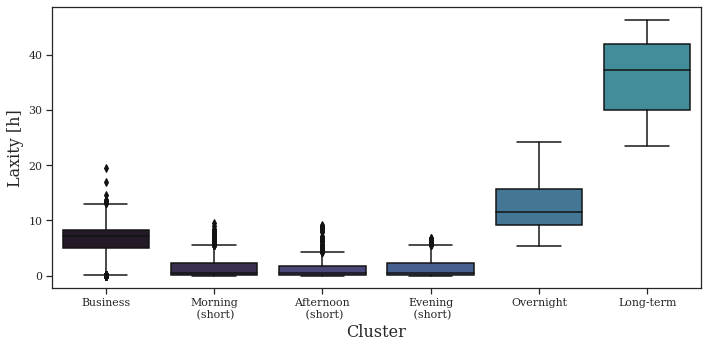

In [21]:
fig,ax = plt.subplots(figsize=(10,5))
order_list = ['Business', 'Morning_short','Afternoon_short', 'Evening_short', 'Overnight', 'Long-term']
sns.boxplot(y="laxity", x="ClusterName", data=parkings, ax=ax, order=order_list)
ax.set_ylabel("Laxity [h]",fontsize=16)
ax.set_xlabel("Cluster",fontsize=16)
ax.set_xticklabels(['Business', 'Morning\n (short)','Afternoon\n (short)', 'Evening\n (short)', 'Overnight', 'Long-term'])
plt.tight_layout()
plt.savefig("laxity_per_parker_type.pdf")
plt.show()

In [25]:
parkings.groupby("ClusterName")["final_kWhRequested_Coll_Filter"].apply(lambda x: x.mean())

ClusterName
Afternoon_short     9.747872
Business           26.759430
Evening_short       9.686040
Long-term          35.148232
Morning_short       8.618956
Overnight          61.866374
Name: final_kWhRequested_Coll_Filter, dtype: float64

In [26]:
parkings.groupby("ClusterName")["final_kWhRequested_Coll_Filter"].apply(lambda x: x.std())

ClusterName
Afternoon_short     9.985906
Business           14.406180
Evening_short      10.610388
Long-term           4.387000
Morning_short       9.190008
Overnight          15.284213
Name: final_kWhRequested_Coll_Filter, dtype: float64

#### Travel Demand Appraoch

Travel Demand Data

In [19]:
data_path = "/Volumes/karsten.schroer@uni-koeln.de/Uni/Research/04_CASE_Clustered_EV_Charging/Travel_Demand_Data/CA_data/data/"

travel_demand = pd.read_csv(data_path+"CA_Travel_survey_trip.csv")
travel_demand = travel_demand[["sampno","perno","tripno","trpmiles","distance_mi","trvlcmin","trptrans17"]]

Limit to car trips only...

__trptrans17:__ Trip Mode

- 03: Car
- 04: SUV
- 06: Pickup Truck
- 05: Van
- (17: Taxi) --> do not consider
- 18: Rental Car

In [20]:
travel_demand_cars = travel_demand[travel_demand["trptrans17"].isin([3,4,6,5,18])==True]

group by sample (i.e., day)

In [21]:
travel_demand_cars_grouped = travel_demand_cars.groupby("sampno").sum()
# remove unreasonably large numbers
travel_demand_cars_grouped = travel_demand_cars_grouped[travel_demand_cars_grouped["distance_mi"]<=travel_demand_cars_grouped["distance_mi"].quantile(q=0.99)]
# remove unreasonably small numbers (likely roundtrips)
travel_demand_cars_grouped = travel_demand_cars_grouped[travel_demand_cars_grouped["distance_mi"]>0.2]

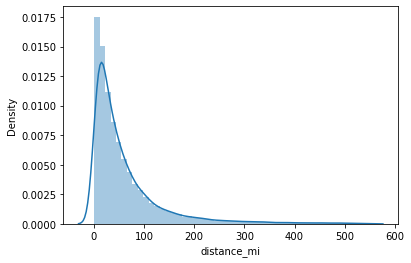

In [22]:
sns.distplot(travel_demand_cars_grouped["distance_mi"])

In [23]:
def generate_daily_distance_traveled(df, travel_demand_path = data_path+"CA_Travel_survey_trip.csv",location="US", seed=42):
    
    us_mean_km = 25.9 * 1.60934 # https://tedb.ornl.gov/data/ Table 9.09
    de_mean_km = (1051+1149)/2/30  #https://mobilitaetspanel.ifv.kit.edu/english/downloads.php; 2019 vehicle miles
    
    #assume exponential distribution
    # It can be shown for the exponential distribution that the mean is equal to the standard deviation; i.e., μ = σ = 1/λ
    
    rng = default_rng(seed=seed)
    
    if location =="US":
        
        #get data and prepare
        travel_demand = pd.read_csv(travel_demand_path)
        travel_demand = travel_demand[["sampno","perno","tripno","trpmiles","distance_mi","trvlcmin","trptrans17"]]
        #limit to relevant transport modes only
        travel_demand_cars = travel_demand[travel_demand["trptrans17"].isin([3,4,6,5,18])==True]
        # group by sample and process
        travel_demand_cars_grouped = travel_demand_cars.groupby("sampno").sum()
        # remove unreasonably large numbers
        travel_demand_cars_grouped = travel_demand_cars_grouped[travel_demand_cars_grouped["distance_mi"]<=travel_demand_cars_grouped["distance_mi"].quantile(q=0.99)]
        # remove unreasonably small numbers (likely roundtrips)
        travel_demand_cars_grouped = travel_demand_cars_grouped[travel_demand_cars_grouped["distance_mi"]>0.2]
        
        #sample randomly with repalcement (need to fit an empirical distribution here!)
        distances = travel_demand_cars_grouped.sample(n=len(df),replace=True,random_state=seed)
        distances = distances["distance_mi"]* 1.60934
        distances = np.array(distances)
        
        #distances = rng.exponential(us_mean_km, size=len(df))
    
    elif location == "DE":
        distances = rng.exponential(de_mean_km, size=len(df))
        
    df["daily_travel_km"] = distances
    
    return df

In [24]:
def generate_home_charging_opportunity(df, home_charging_share, seed=42):
    #Brenoulli Process that assigns home charging with probability p(HomeCharging) = home_charging_share
    
    rng = default_rng(seed=seed)
    
    home_charging_array = rng.choice([0, 1], p=[1 - home_charging_share, home_charging_share], size=len(df))
    
    df["home_charging_yn"] = home_charging_array
    
    return df

In [25]:
def generate_energy_demand_travel_based_approach(df,ev_share=0.5,min_stay_minutes=20,home_charging_share=0.8,
                                                 max_charge_rate=22,
                                                 location="US",seed=42):
    df = sample_electric_vehicles(df, ev_share=ev_share, seed=seed)
    df = sample_charge_request_yn(df,min_stay_minutes=min_stay_minutes)
    df = generate_daily_distance_traveled(df, location=location, seed=seed)
    df = generate_home_charging_opportunity(df, home_charging_share=home_charging_share, seed=seed)
    
    # energy per km
    kWh_per_km = 18.5/100 #Tesal Model S75
    kWh_per_km = round(0.2306631886256587,3) # mean of ACN sample
    
    # base charging demand'
    df["final_kWhRequested_travel_demand"] = df.apply(lambda x: x.daily_travel_km*kWh_per_km if x.request_charge_yn==1 and x.EV_yn==1 else 0, axis=1)                  
    
    # charging energy (if home charging = yes, divide by 2)
    #df["final_kWhRequested_travel_demand"] = df.apply(lambda x: x.final_kWhRequested_travel_demand/2 if x.home_charging_yn==1 else x.final_kWhRequested_travel_demand, axis=1)                                     
    
    # ensure realistic charge request (i.e., fulfillment physically possible at max charge rate)
    df["final_kWhRequested_travel_demand"] = df.apply(lambda x: x.MinutesStay/60*max_charge_rate if x.final_kWhRequested_travel_demand>=x.MinutesStay/60*max_charge_rate
                                                    else x.final_kWhRequested_travel_demand, axis=1)
    
    max_battery_size = 100  # kWh
    df["final_kWhRequested_travel_demand"] = df["final_kWhRequested_travel_demand"].apply(lambda x: max_battery_size if x > max_battery_size else x)

    #round
    df["final_kWhRequested_travel_demand"] = df["final_kWhRequested_travel_demand"].apply(lambda x: round(x,ndigits=2))
    
    return df

In [26]:
parkings = generate_energy_demand_travel_based_approach(df=parkings,ev_share=0.25,min_stay_minutes=20,home_charging_share=0.8,max_charge_rate=22,location="US",seed=42)

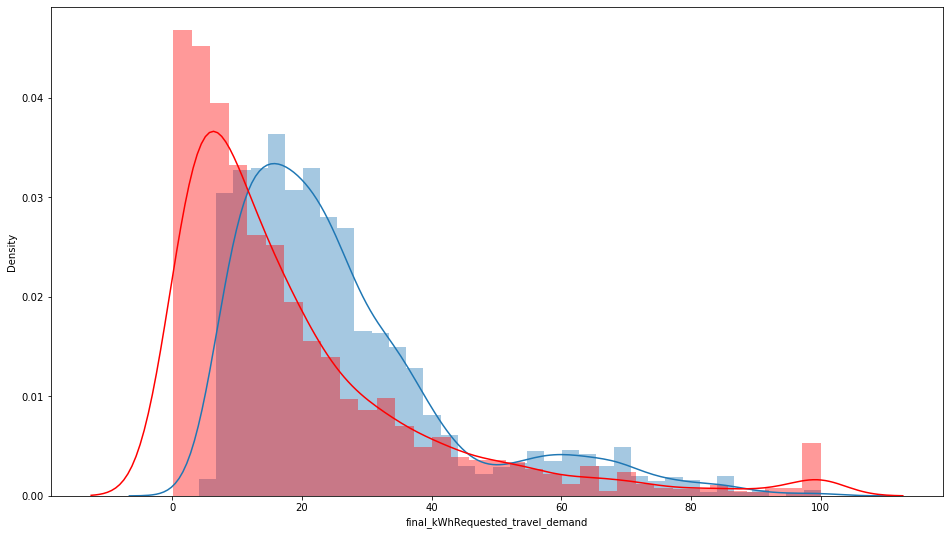

In [27]:
fig,ax = plt.subplots(figsize=(16,9))

sns.distplot(parkings[parkings["request_charge_yn"]==1]["final_kWhRequested_Coll_Filter"],ax=ax)
sns.distplot(parkings[parkings["request_charge_yn"]==1]["final_kWhRequested_travel_demand"],ax=ax,color="red")

#sns.distplot(parkings["final_kWhRequested_Coll_Filter"],ax=ax)
#sns.distplot(parkings["final_kWhRequested_travel_demand"],ax=ax,color="red")

In [28]:
parkings[parkings["request_charge_yn"]==1]["final_kWhRequested_Coll_Filter"].mean()

26.456013904982623

In [30]:
parkings[parkings["request_charge_yn"]==1]["final_kWhRequested_Coll_Filter"].std()

17.191780570665586

In [29]:
parkings[parkings["request_charge_yn"]==1]["final_kWhRequested_travel_demand"].mean()

19.32494785631518

In [31]:
parkings[parkings["request_charge_yn"]==1]["final_kWhRequested_travel_demand"].std()

20.278473420859626

---